# Проект для «Викишоп» с BERT

## Описание проекта
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Нужно построить модель со значением метрики качества F1 не меньше 0.75.

## Описание данных
Столбец text в нём содержит текст комментария, а toxic — целевой признак.

## Загрузка библиотек

In [ ]:
! pip install -q nltk

In [ ]:
!pip install -q wordcloud
from wordcloud import WordCloud, STOPWORDS

In [ ]:
! pip install -q catboost
from catboost import Pool, CatBoostClassifier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.8 MB/s eta 0:00:00


In [ ]:
! pip install -q pytorch-transformers
from pytorch_transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 15.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 14.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import matplotlib.style
%matplotlib inline

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = 'seaborn'

from IPython.display import clear_output
import matplotlib.pyplot as plt
import io

# Обработка текста
import re
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import TfidfVectorizer

# ML
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# Другое
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')
import time
from tqdm import tqdm

# Загрузка файлов с диска
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Mounted at /content/drive


## Загрузка и изучение данных

In [ ]:
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/10_toxic_comments.csv', index_col=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0])

display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

In [ ]:
display(df.head())
display(df.tail())

text  toxic
0  Explanation\nWhy the edits made under my usern...      0
1  D'aww! He matches this background colour I'm s...      0
2  Hey man, I'm really not trying to edit war. It...      0
3  "\nMore\nI can't make any real suggestions on ...      0
4  You, sir, are my hero. Any chance you remember...      0

text  toxic
159446  ":::::And for the second time of asking, when ...      0
159447  You should be ashamed of yourself \n\nThat is ...      0
159448  Spitzer \n\nUmm, theres no actual article for ...      0
159449  And it looks like it was actually you who put ...      0
159450  "\nAnd ... I really don't think you understand...      0

In [ ]:
# проверка на дубликаты
print(f"Количество дубликатов: {df.duplicated().sum()}")

Количество дубликатов: 0


**Видим, что:**
1. датафрейм содержит 2 признака и 159292 объекта в каждом из них - пропусков в данных нет;
2. для признака text необходимо провести предобработку:
 - необходимо очистить комментарии от лишних слов,
 - провести токенизацию (разбиение текста на токены, т.е., отдельные фразы, слова, символы),
 - лемматизацию текста (приведение слова к начальной форме или лемме).

## Анализ данных

In [ ]:
# Посмотрим на соотношение нейтральных и токсичных комментариев:
values = df['toxic'].value_counts()
values = values.to_frame().reset_index()
values.columns = ['Boolean', 'Count']
values['Percentage'] = df['toxic'].value_counts(normalize=True)
pd.DataFrame(values)

values['Category'] = values['Boolean'].apply(lambda x: 'Toxic' if x == True else 'Neutral')
values

Boolean   Count  Percentage Category
0        0  143106    0.898388  Neutral
1        1   16186    0.101612    Toxic

In [ ]:
fig = make_subplots(rows = 1, cols = 2,
                    specs = [[{"type": "bar"}, {"type": "pie"}]],
                    subplot_titles = ('К-во комментариев по группам',
                                      'Доля комментариев по группам'))

fig.add_trace(go.Bar(x = values['Category'], y = values['Count']), row = 1, col = 1)
fig.add_trace(go.Pie(values = values['Percentage'], labels = values['Category']), row = 1, col = 2)

fig.update_layout(height = 450, showlegend = False, title_text = 'Комментарии в зависимости от их тональности')
fig.show();

> Видим, что почти 90% комментариев имеет нейтральную или позитивную тональность, а 10 - негативную, т.е., каждый 10-й комментарий можно трактовать как токсичный.

## Предобработка текста

In [ ]:
# Создадим копию датафрейма:
comments = df.copy()
comments.shape

(159292, 2)

In [ ]:
comments['text'] = comments['text'].str.lower()

In [ ]:
comments.head(3)

text  toxic
0  explanation\nwhy the edits made under my usern...      0
1  d'aww! he matches this background colour i'm s...      0
2  hey man, i'm really not trying to edit war. it...      0

In [ ]:
comments_new = []
pattern = r'[^a-zA-Z0-9]'
for sentence in comments.text:
  cleared_text = re.sub(pattern, " ", sentence)
  comments_new.append(" ". join(cleared_text.split()))

In [ ]:
comments['clear_text'] = comments_new
comments.head(3)

text  toxic  \
0  explanation\nwhy the edits made under my usern...      0   
1  d'aww! he matches this background colour i'm s...      0   
2  hey man, i'm really not trying to edit war. it...      0   

                                          clear_text  
0  explanation why the edits made under my userna...  
1  d aww he matches this background colour i m se...  
2  hey man i m really not trying to edit war it s...

In [ ]:
# инициализация Wordnet Lemmatizer
L = WordNetLemmatizer()

In [ ]:
def lemmatizered(corpus):
    corpus_new = []
    for sentence in corpus:
        word_list = nltk.word_tokenize(sentence)
        corpus_new.append(' '.join([L.lemmatize(w) for w in word_list]))
    return corpus_new

In [ ]:
nltk.download('stopwords')
stopwords.words('english')[:5]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i', 'me', 'my', 'myself', 'we']

In [ ]:
def get_wordnet_pos(word):
    """функция возвращает словарь, где возвращается значение часть речи (pos_tag)"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [ ]:
def get_word_text(corpus):
    corpus_new = []
    for sentence in corpus:
        corpus_new.append(' '.join([L.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(sentence) if not w in stopwords.words('english')]))
    return corpus_new

In [ ]:
%%time
comments['lemmas'] = get_word_text(comments['clear_text'])

CPU times: user 32min 23s, sys: 3min 11s, total: 35min 35s
Wall time: 36min 5s


In [ ]:
comments.head(3)


text  toxic  \
0  explanation\nwhy the edits made under my usern...      0   
1  d'aww! he matches this background colour i'm s...      0   
2  hey man, i'm really not trying to edit war. it...      0   

                                          clear_text  \
0  explanation why the edits made under my userna...   
1  d aww he matches this background colour i m se...   
2  hey man i m really not trying to edit war it s...   

                                              lemmas  
0  explanation edits make username hardcore metal...  
1  aww match background colour seemingly stuck th...  
2  hey man really try edit war guy constantly rem...

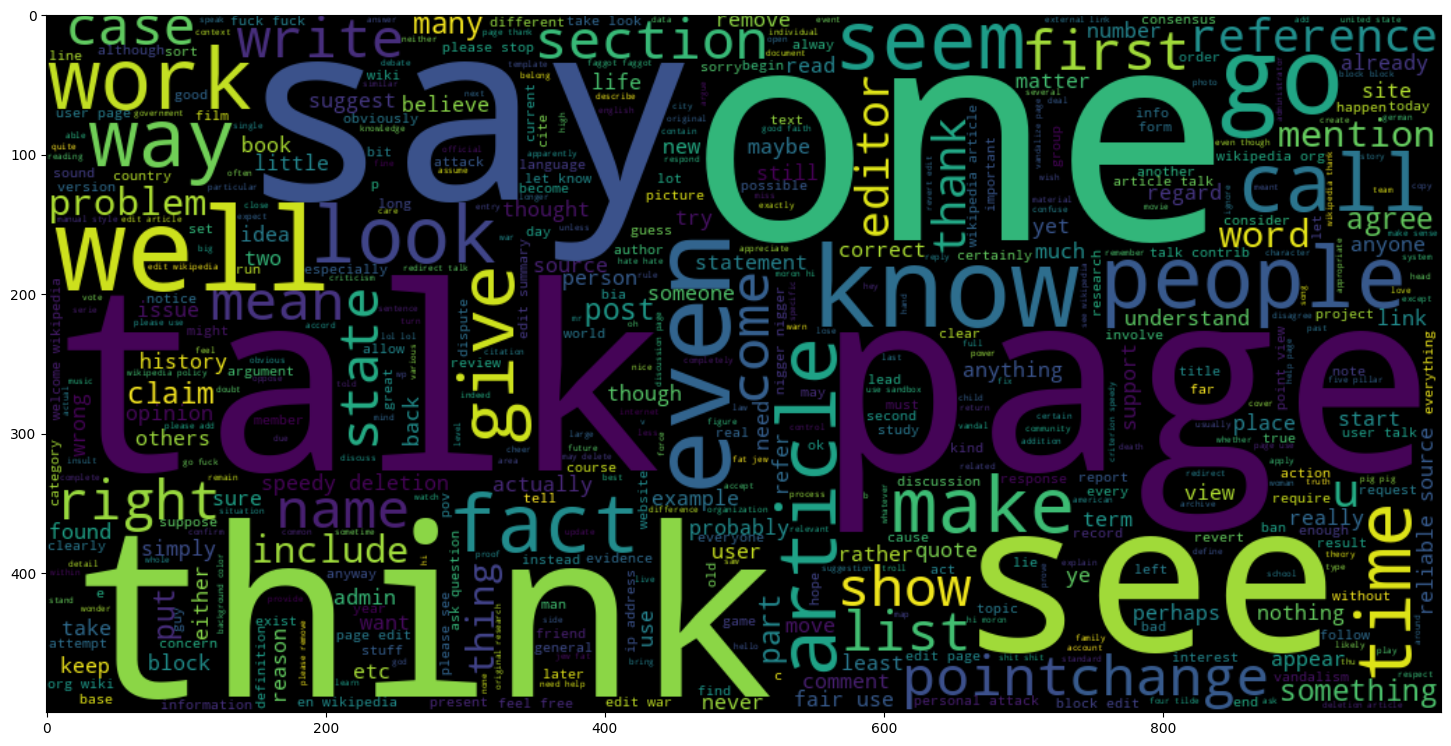

In [ ]:
plt.figure(figsize=(18,18))
text = ' '.join(comments['lemmas'].values)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.show;

In [ ]:
train = []
# потребуется для WordCloud
for sentences in comments['lemmas']:
  train.append(sentences.split())

comments['split'] = train

In [ ]:
# Отфильтруем комментарии в зависимости от того, какую тональность они имеют:
all_list = list(comments['split'])
comments_all = [item for sublist in all_list for item in sublist]

neutral = comments.query('toxic == 0')
neutral_list = list(neutral['split'])
comments_neutral = [item for sublist in neutral_list for item in sublist]

toxic = comments.query('toxic == 1')
toxic_list = list(toxic['split'])
comments_toxic = [item for sublist in toxic_list for item in sublist]

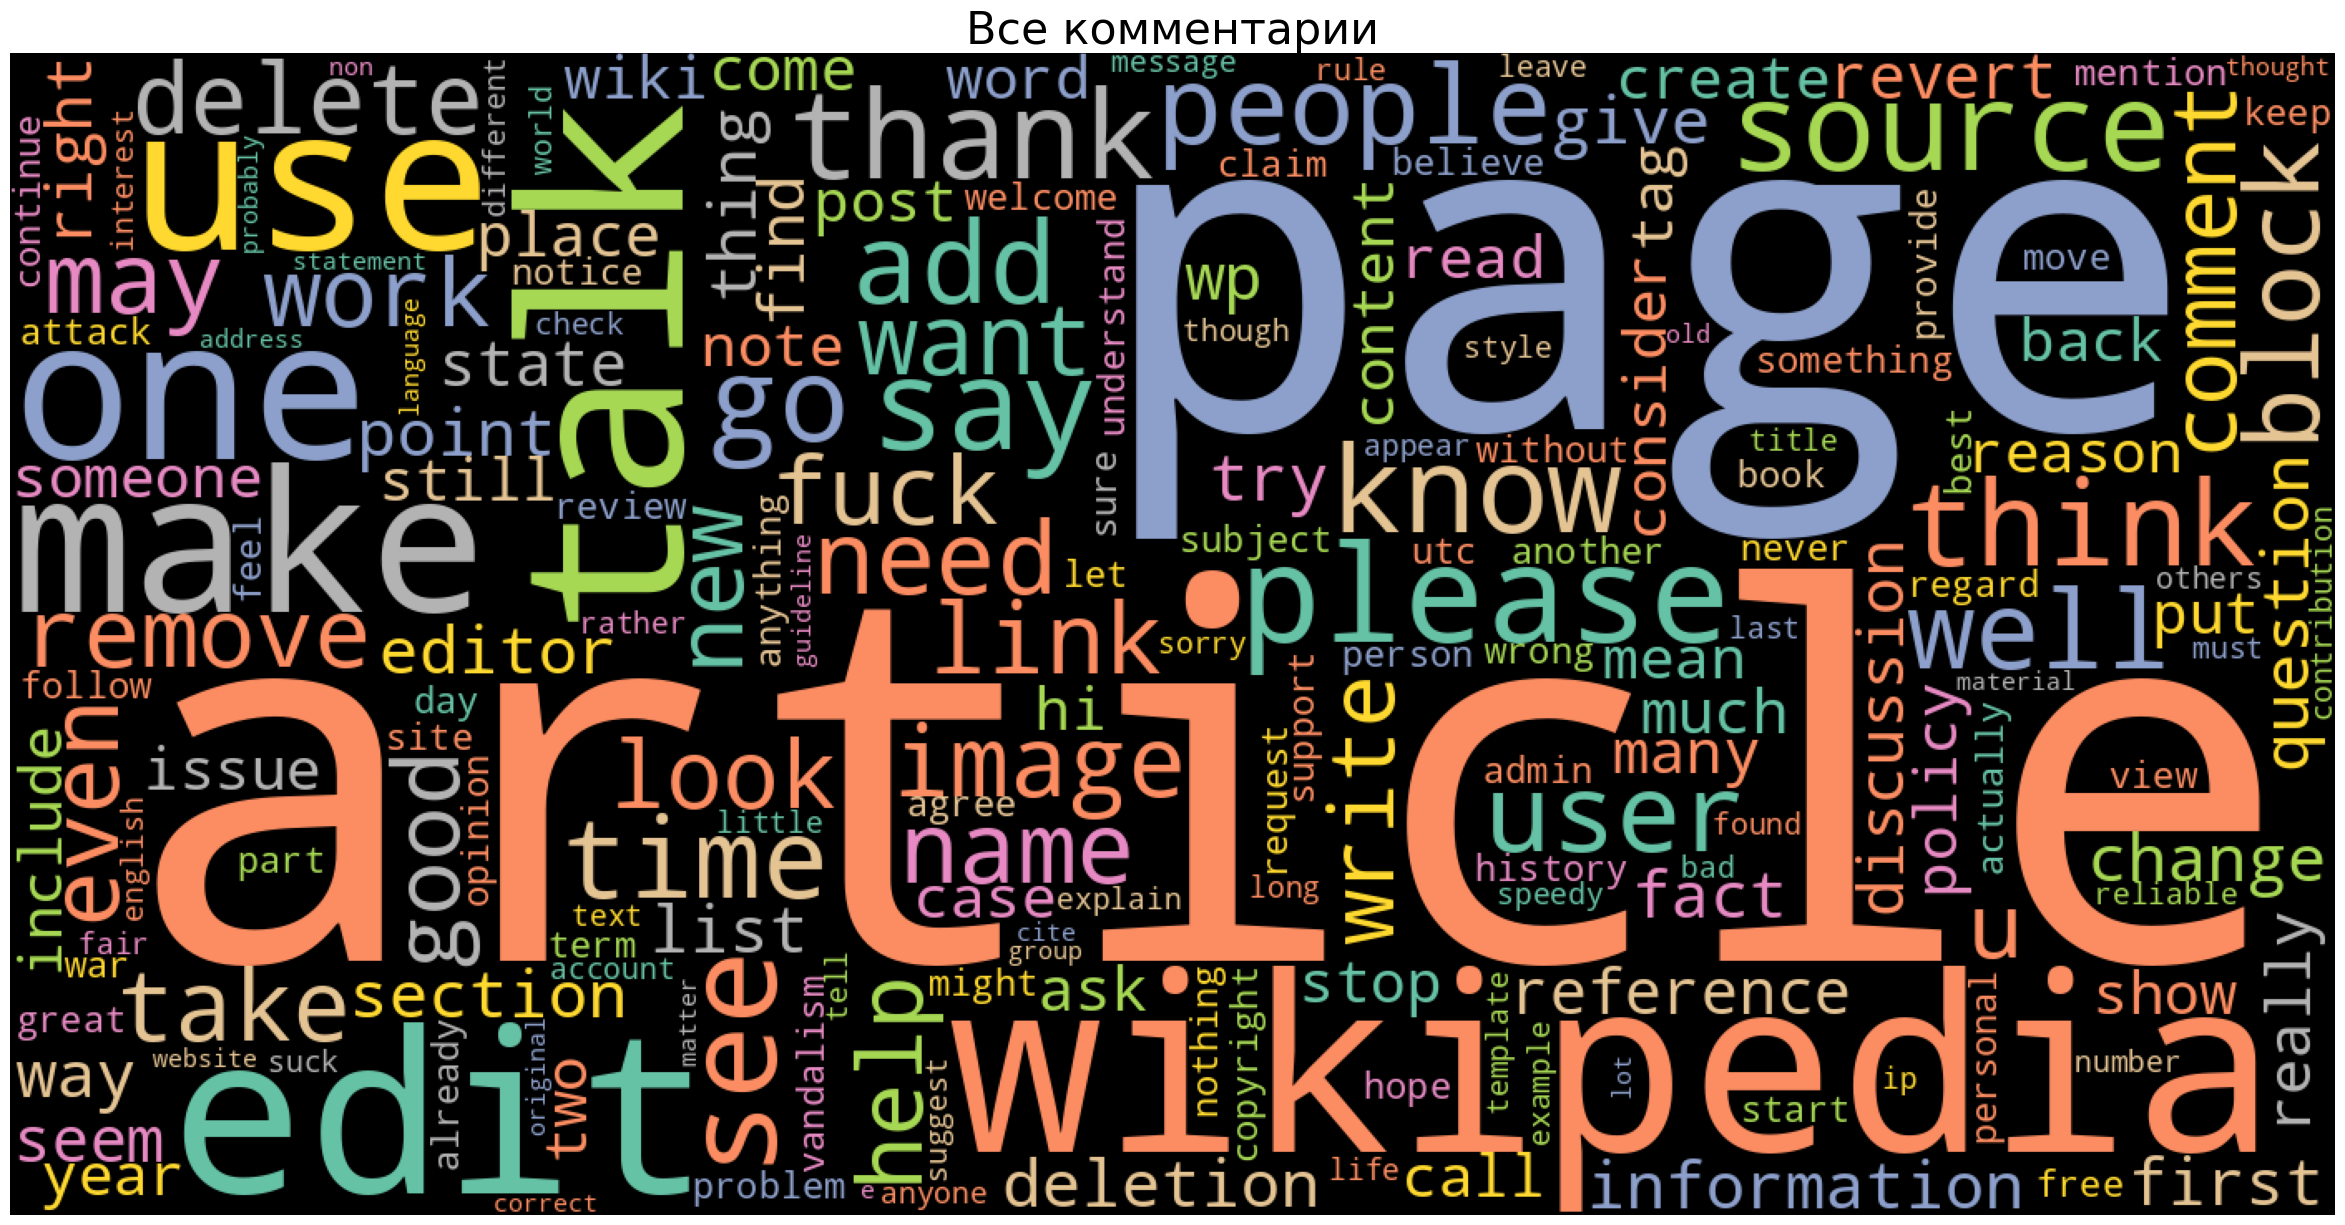

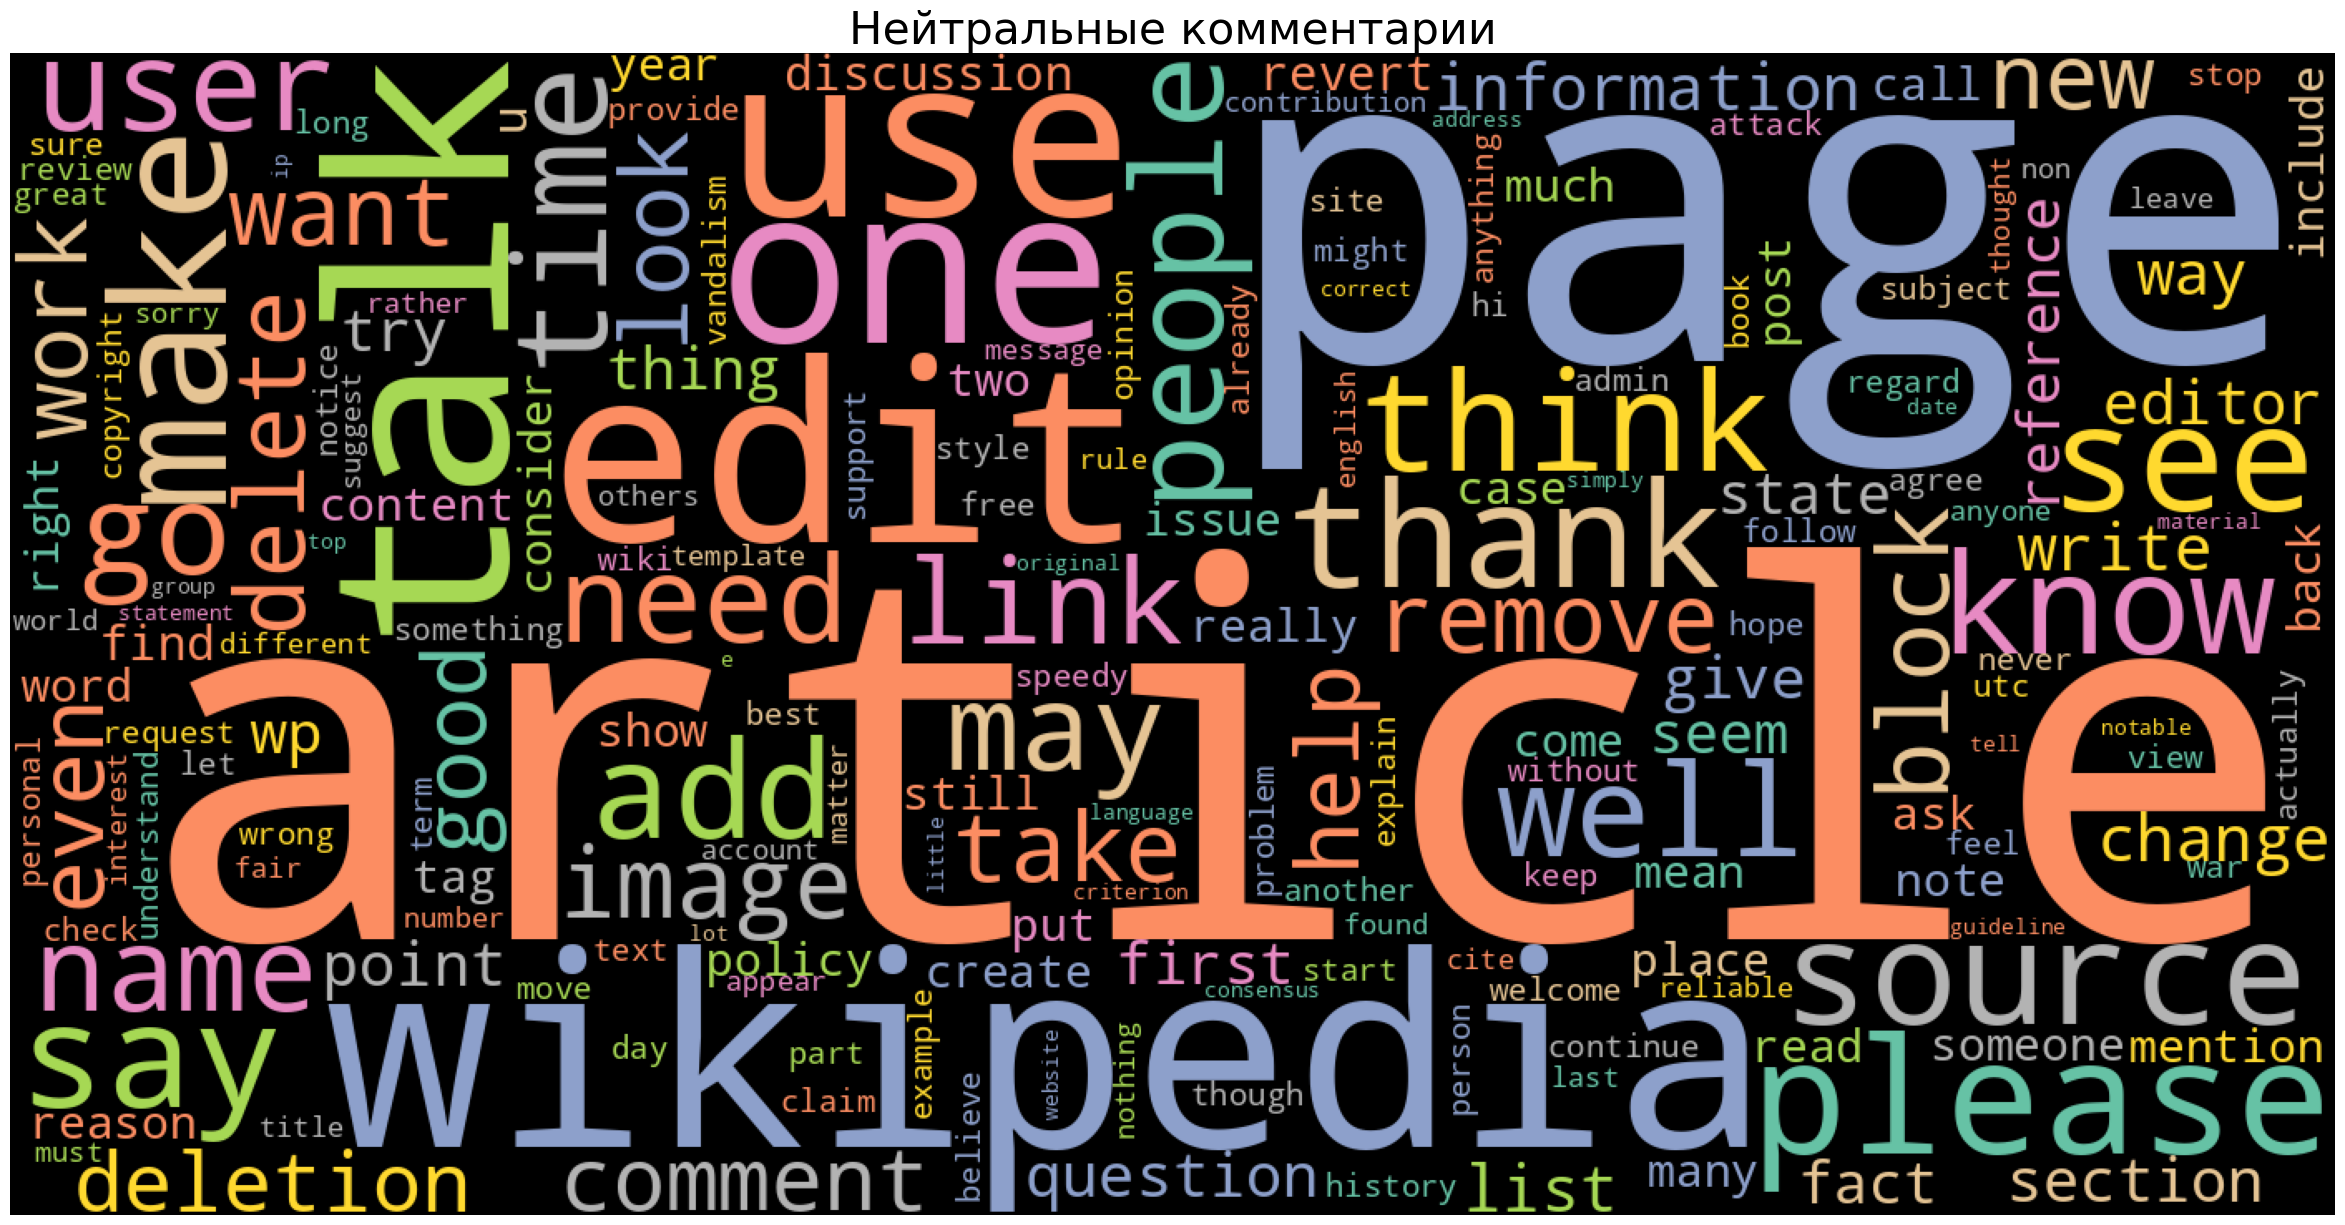

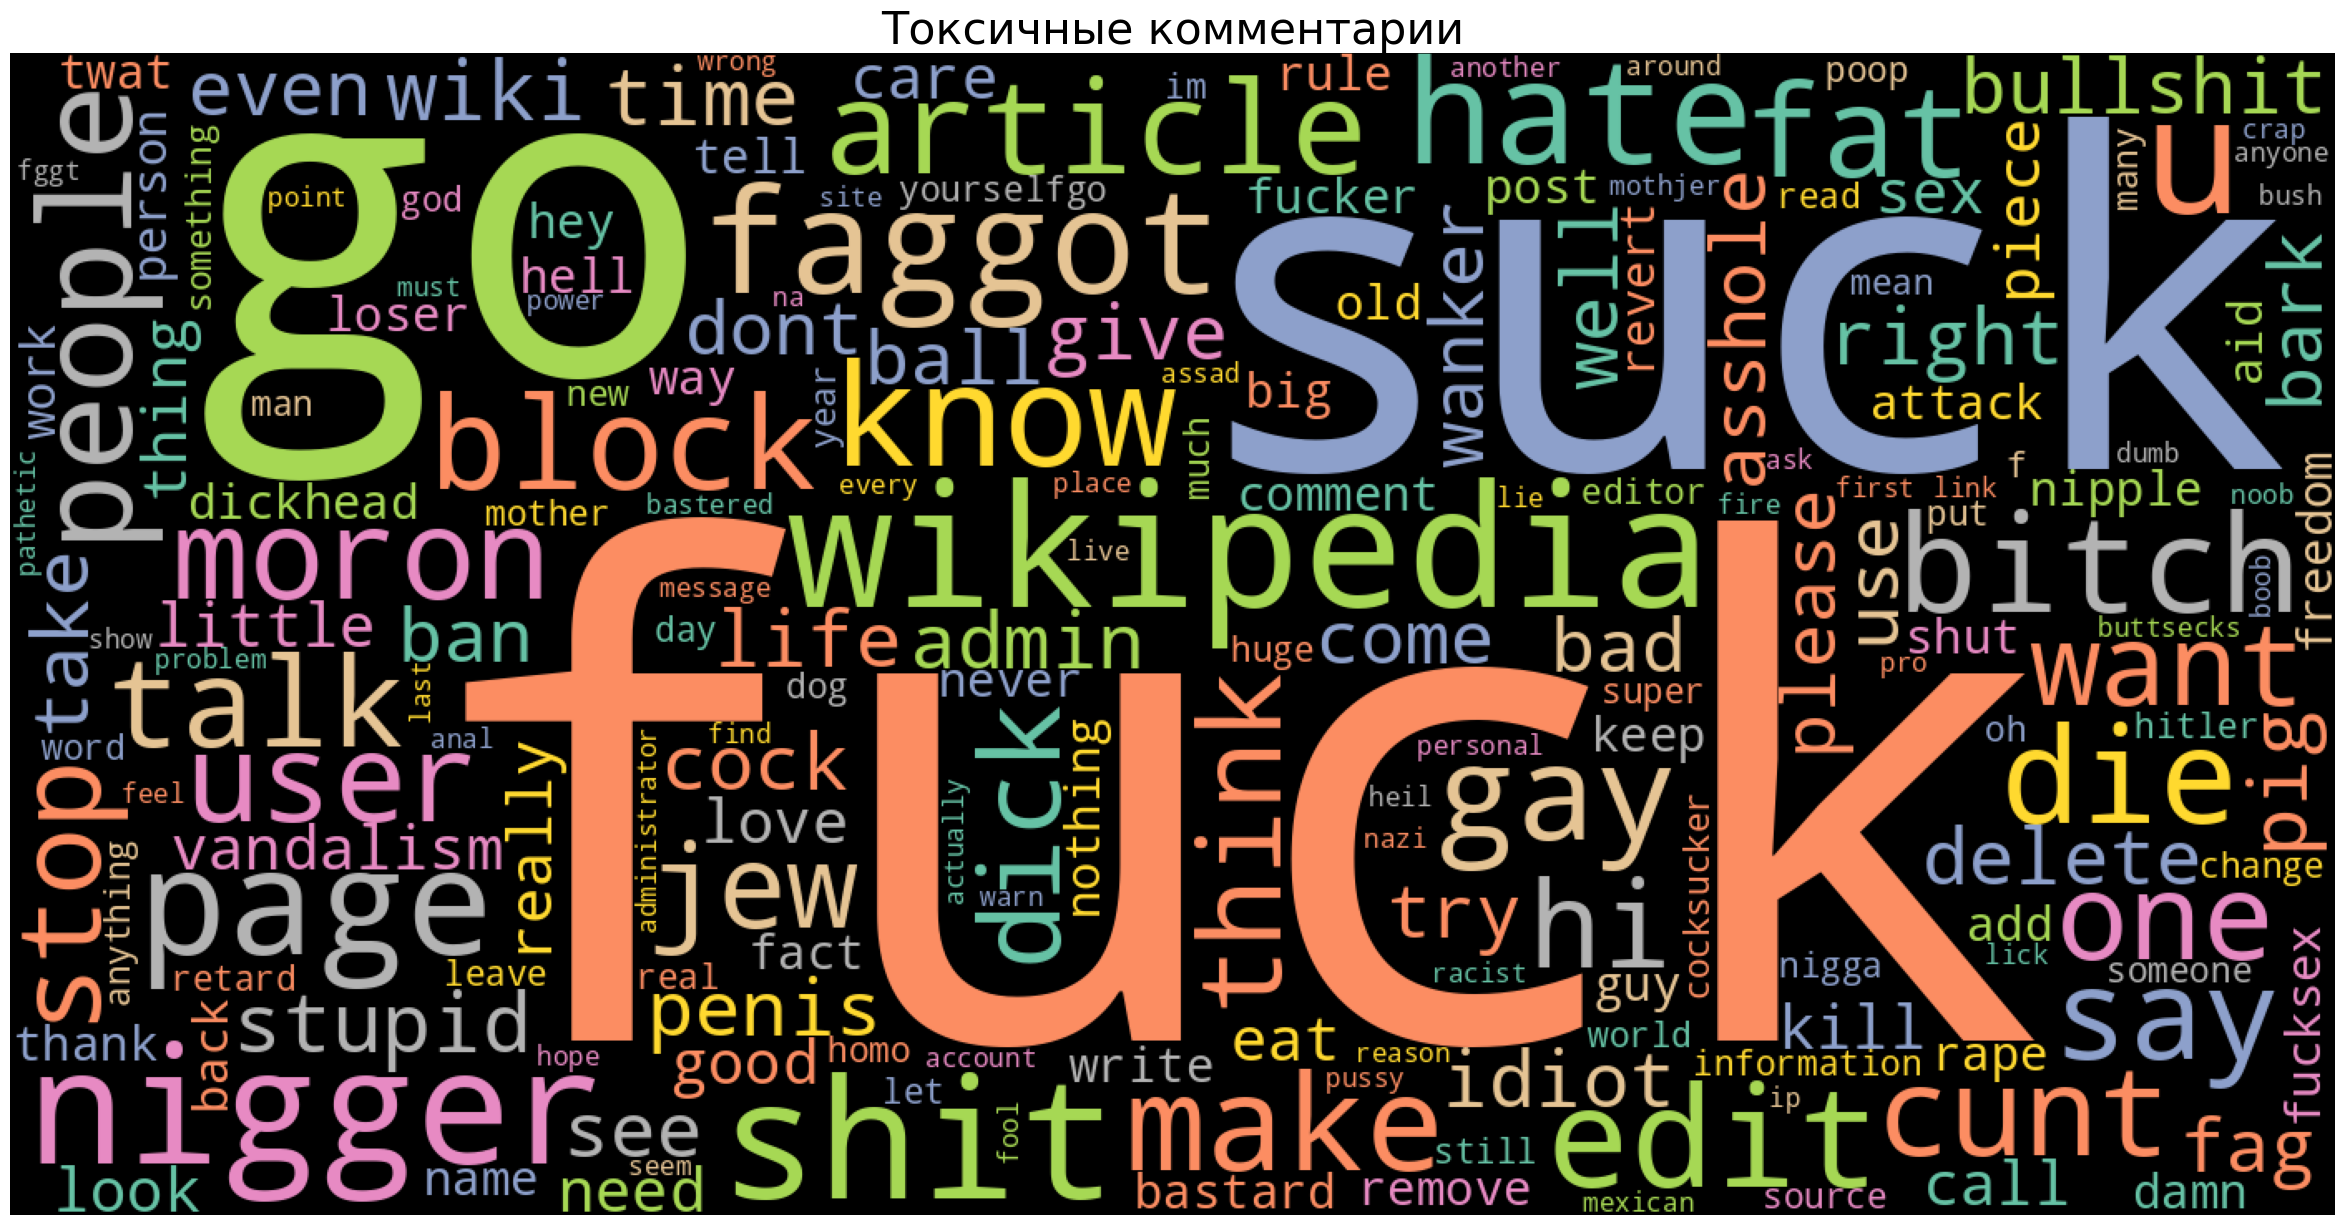

In [ ]:
# Визуализируем результат:
lists_of_comments_by_type = {'Все комментарии' : comments_all,
                             'Нейтральные комментарии': comments_neutral,
                             'Токсичные комментарии': comments_toxic}
random = 12345
for key, value in lists_of_comments_by_type.items():

    wordcloud = WordCloud(random_state=random,
                          width = 1400,
                          height = 700,
                          background_color='black',
                          colormap='Set2',
                          collocations=False,
                          stopwords = STOPWORDS).generate(' '.join(w for w in value))

    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(key, fontsize=32)

## Обучение

### Подготовка данных к обучению

In [ ]:
# Разделим датасет на тестовую и тренировочную выборку, размер тестовой выборки - 10% от общих данных:
X_train, X_test, y_train, y_test = train_test_split(comments.drop('toxic', axis=1),
                                                    comments['toxic'],
                                                    train_size=0.9,
                                                    test_size=0.1,
                                                    random_state=random,
                                                    # стратифицируем текст, чтобы выборки были более сбалансированы
                                                    stratify=comments['toxic']
                                                   )

In [ ]:
# Посмотрим на размеры выборок:
samples = {'Размер обучающей выборки' : X_train,
           'Размер тестовой выборки': X_test}

for key, value in samples.items():
    print(key + ':', value.shape)

Размер обучающей выборки: (143362, 4)
Размер тестовой выборки: (15930, 4)


In [ ]:
# Вытаскиваем корпусы
corpus_train = X_train['lemmas']
corpus_test = X_test['lemmas']
corpus_test[:3]

149338    fred c seem impression give shit think america...
121099    name jesse lipp sophmore need additonal infoma...
102168      joke honestly everyone need get back everything
Name: lemmas, dtype: object

In [ ]:
def result_write(model_name,f1,time_fit):
  '''
  функция добавляет значения метрики f1 по умолчания, f1 c учетом измененного порога,
  порог, время настройки модели
  '''
  result_df.loc[model_name,'F1_predict'] = f1
  result_df.loc[model_name,'Time_fit'] = time_fit
  return result_df

### LinearSVC

In [ ]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer()),
        ("clf", LinearSVC()),
    ]
)

In [ ]:
parameter_grid = {
    "vect__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vect__min_df": (1, 3, 5, 10),
    "vect__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "vect__norm": ("l1", "l2"),
    "clf__C": np.linspace(1, 31, num = 7, endpoint = True)
}

In [ ]:
random_search = RandomizedSearchCV(estimator=pipeline,
                                   param_distributions=parameter_grid,
                                   scoring='f1',
                                   n_iter=20,
                                   random_state=random,
                                   n_jobs=2,
                                   verbose=1)

In [ ]:
start = time.time()
random_search.fit(corpus_train, y_train)
end = time.time()
time_fit_lsvc = end - start
print(f"Done in {time_fit_lsvc:.3f}s")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Done in 1567.527s


In [ ]:
print('Лучшие параметры:')
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

Лучшие параметры:
clf__C: 11.0
vect__max_df: 0.6
vect__min_df: 1
vect__ngram_range: (1, 2)
vect__norm: l2


In [ ]:
acc_score_lsvc = random_search.score(corpus_test, y_test)
print('Процент правильных предсказаний на тестовой выборке составил: {0:.2f}%'.format(acc_score_lsvc*100))

Процент правильных предсказаний на тестовой выборке составил: 79.91%


In [ ]:
f1_lsvc = f1_score(random_search.predict(corpus_test), y_test)

In [ ]:
result_df = pd.DataFrame(columns=['F1_predict','Time_fit'])

In [ ]:
result_write('LinearSVC', f1_lsvc, time_fit_lsvc)

F1_predict     Time_fit
LinearSVC   0.799069  1567.526717

### CatBoostClassifier

#### Подготовка данных к обучению:

In [ ]:
# Для дальнейшего использования (и чтобы не умереть в ожидании) нам такой большой датасет не нужен,
# поэтому сделаем sample:
sample_size = 30000
corpus = comments.sample(n=sample_size,random_state=random).reset_index(drop=True)
print('соотношение классов в датасете corpus\n', corpus.toxic.value_counts()/corpus.shape[0]*100)

соотношение классов в датасете corpus
 0    89.86
1    10.14
Name: toxic, dtype: float64


> Соотношение классов получилось примерно как в исходном датасете.

In [ ]:
# Разделим наши данные на тренировочную и тестовую выборки:
train_corpus, test_corpus = train_test_split(corpus,
                                             test_size=0.2,
                                             random_state=random,
                                             stratify = corpus['toxic']
)

In [ ]:
train_corpus.head()

text  toxic  \
16024                      please check it. — '''' (t/c)      0   
22346                        thanks for your comments! )      0   
6426   "\n\nhrmm, gotcha.. i thought it was okay sinc...      0   
14973  "\n\n david beckham \n\nthank you for that hil...      0   
29869  "\ni do not support ""military criminal elemen...      0   

                                              clear_text  \
16024                                please check it t c   
22346                           thanks for your comments   
6426   hrmm gotcha i thought it was okay since most o...   
14973  david beckham thank you for that hilarious edi...   
29869  i do not support military criminal elements bu...   

                                                  lemmas  \
16024                                     please check c   
22346                                     thanks comment   
6426   hrmm gotcha thought okay since leader civiliza...   
14973  david beckham thank hilarious edit summary tal...   
29869  support military criminal element support bala...   

                                                   split  
16024                                 [please, check, c]  
22346                                  [thanks, comment]  
6426   [hrmm, gotcha, thought, okay, since, leader, c...  
14973  [david, beckham, thank, hilarious, edit, summa...  
29869  [support, military, criminal, element, support...

In [ ]:
print('соотношение классов в train_corpus n', train_corpus.toxic.value_counts()/train_corpus.shape[0]*100)
print('соотношение классов в test_corpus n', test_corpus.toxic.value_counts()/test_corpus.shape[0]*100)

соотношение классов в train_corpus n 0    89.858333
1    10.141667
Name: toxic, dtype: float64
соотношение классов в test_corpus n 0    89.866667
1    10.133333
Name: toxic, dtype: float64


In [ ]:
text_features = ['lemmas']
target = ['toxic']

Для простоты зададим токенизацию по пробелу - создадим 2-6 gram'ы (нужно создать соответствующие словари) и выполним подсчет признаков (укажим какие признаки подсчитываем на словаре).

In [ ]:
cat = CatBoostClassifier(
    text_features=text_features,
    verbose=50,
    loss_function='Logloss',
    eval_metric='F1',
    task_type="GPU",
    iterations=1000,
    learning_rate=0.2,
    random_seed = random,
    auto_class_weights = 'Balanced',
    text_processing = {
        "tokenizers" : [{
            "tokenizer_id" : "Space",
            "separator_type" : "ByDelimiter",
            "delimiter" : " "
        }],

        "dictionaries" : [{
            "dictionary_id" : "BiGram",
            "token_level_type": "Letter",
            "max_dictionary_size" : "150000",
            "occurrence_lower_bound" : "1",
            "gram_order" : "2"
        },{
            "dictionary_id" : "Trigram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "3"
        },{
            "dictionary_id" : "Fourgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "4"
        },{
            "dictionary_id" : "Fivegram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "5"
        },{
            "dictionary_id" : "Sixgram",
            "max_dictionary_size" : "150000",
            "token_level_type": "Letter",
            "occurrence_lower_bound" : "1",
            "gram_order" : "6"
        }
        ],

        "feature_processing" : {
            "default" : [
                    {
                    "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                    "feature_calcers" : ["BoW"],
                    "tokenizers_names" : ["Space"]
                },
                    {
                "dictionaries_names" : ["BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["NaiveBayes"],
                "tokenizers_names" : ["Space"]
            },{
                "dictionaries_names" : [ "BiGram", "Trigram", "Fourgram", "Fivegram", "Sixgram"],
                "feature_calcers" : ["BM25"],
                "tokenizers_names" : ["Space"]
            },
            ],
        }
    }
)

#### Обучение модели:

In [ ]:
start = time.time()
cat.fit(
    train_corpus[text_features], train_corpus[target],
    eval_set=(test_corpus[text_features], test_corpus[target]),
    plot=True
)
end = time.time()
time_fit_cat = end - start

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8245207	test: 0.8421066	best: 0.8421066 (0)	total: 90.9ms	remaining: 1m 30s
50:	learn: 0.8845655	test: 0.8648739	best: 0.8648739 (50)	total: 4.65s	remaining: 1m 26s
100:	learn: 0.9063637	test: 0.8670694	best: 0.8677193 (91)	total: 6.87s	remaining: 1m 1s
150:	learn: 0.9191159	test: 0.8713766	best: 0.8740728 (137)	total: 9.16s	remaining: 51.5s
200:	learn: 0.9290138	test: 0.8723631	best: 0.8740728 (137)	total: 11.5s	remaining: 45.6s
250:	learn: 0.9351720	test: 0.8695703	best: 0.8740728 (137)	total: 13.7s	remaining: 41s
300:	learn: 0.9442980	test: 0.8671919	best: 0.8740728 (137)	total: 18.6s	remaining: 43.2s
350:	learn: 0.9488777	test: 0.8650560	best: 0.8740728 (137)	total: 21.1s	remaining: 39s
400:	learn: 0.9539050	test: 0.8634225	best: 0.8740728 (137)	total: 23.4s	remaining: 34.9s
450:	learn: 0.9565725	test: 0.8669059	best: 0.8740728 (137)	total: 25.7s	remaining: 31.3s
500:	learn: 0.9609627	test: 0.8652404	best: 0.8740728 (137)	total: 28s	remaining: 27.9s
550:	learn: 0.964414

In [ ]:
f1_cat = f1_score(cat.predict(test_corpus[text_features]),test_corpus[target])

In [ ]:
result_write('Catboost', f1_cat, time_fit_cat)

F1_predict     Time_fit
LinearSVC   0.799069  1567.526717
Catboost    0.695833   124.345692

### Word2Vec + CatBoostClassifier

In [ ]:
class GensimWord2VecVectorizer(BaseEstimator, TransformerMixin):
    """
    Word vectors are averaged across to create the document-level vectors/features.
    gensim's own gensim.sklearn_api.W2VTransformer doesn't support out of vocabulary words,
    hence we roll out our own.
    All the parameters are gensim.models.Word2Vec's parameters.
    https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec
    """

    def __init__(self, size=100, alpha=0.025, window=5, min_count=5, max_vocab_size=None,
                 sample=0.001, seed=1, workers=3, min_alpha=0.0001, sg=0, hs=0, negative=5,
                 ns_exponent=0.75, cbow_mean=1, hashfxn=hash, iter=5, null_word=0,
                 trim_rule=None, sorted_vocab=1, batch_words=10000, compute_loss=False,
                 callbacks=(), max_final_vocab=None):
        self.size = size
        self.alpha = alpha
        self.window = window
        self.min_count = min_count
        self.max_vocab_size = max_vocab_size
        self.sample = sample
        self.seed = seed
        self.workers = workers
        self.min_alpha = min_alpha
        self.sg = sg
        self.hs = hs
        self.negative = negative
        self.ns_exponent = ns_exponent
        self.cbow_mean = cbow_mean
        self.hashfxn = hashfxn
        self.iter = iter
        self.null_word = null_word
        self.trim_rule = trim_rule
        self.sorted_vocab = sorted_vocab
        self.batch_words = batch_words
        self.compute_loss = compute_loss
        self.callbacks = callbacks
        self.max_final_vocab = max_final_vocab

    def fit(self, X, y=None):
        self.model_ = Word2Vec(
            sentences=X, corpus_file=None,
            vector_size=self.size, alpha=self.alpha, window=self.window, min_count=self.min_count,
            max_vocab_size=self.max_vocab_size, sample=self.sample, seed=self.seed,
            workers=self.workers, min_alpha=self.min_alpha, sg=self.sg, hs=self.hs,
            negative=self.negative, ns_exponent=self.ns_exponent, cbow_mean=self.cbow_mean,
            hashfxn=self.hashfxn, epochs=self.iter, null_word=self.null_word,
            trim_rule=self.trim_rule, sorted_vocab=self.sorted_vocab, batch_words=self.batch_words,
            compute_loss=self.compute_loss, callbacks=self.callbacks,
            max_final_vocab=self.max_final_vocab)
        return self

    def transform(self, X):
        X_embeddings = np.array([self._get_embedding(words) for words in X])
        return X_embeddings

    def _get_embedding(self, words):
        valid_words = [word for word in words if word in self.model_.wv]
        if valid_words:
            embedding = np.zeros((len(valid_words), self.size), dtype=np.float32)
            for idx, word in enumerate(valid_words):
                embedding[idx] = self.model_.wv[word]

            return np.mean(embedding, axis=0)
        else:
            return np.zeros(self.size)

In [ ]:
gensim_word2vec_tr = GensimWord2VecVectorizer(size=50, min_count=2,window=5, sg=1, alpha=0.025, iter=10)

In [ ]:
cat_w2v = CatBoostClassifier(verbose=50,
                             loss_function='Logloss',
                             eval_metric='F1',
                             task_type="GPU",
                             iterations=2000,
                             learning_rate=0.1,
                             auto_class_weights = 'Balanced'
)

CAT_w2v = Pipeline(
    [
    ('w2v', gensim_word2vec_tr),
    ('cat_w2v', cat_w2v)
    ]
)
CAT_w2v

Pipeline(steps=[('w2v',
                 GensimWord2VecVectorizer(iter=10, min_count=2, sg=1, size=50)),
                ('cat_w2v',
                 <catboost.core.CatBoostClassifier object at 0x7c665a3ade70>)])

In [ ]:
start = time.time()
CAT_w2v.fit(train_corpus['split'], train_corpus['toxic'],
           )
time_fit_w2w = time.time() - start
print('Время выполнения: ', time_fit_w2w)
CAT_w2v

0:	learn: 0.8342107	total: 158ms	remaining: 5m 15s
50:	learn: 0.8937335	total: 3.33s	remaining: 2m 7s
100:	learn: 0.9082087	total: 4.86s	remaining: 1m 31s
150:	learn: 0.9172932	total: 6.42s	remaining: 1m 18s
200:	learn: 0.9269611	total: 7.98s	remaining: 1m 11s
250:	learn: 0.9348096	total: 9.56s	remaining: 1m 6s
300:	learn: 0.9421278	total: 11.1s	remaining: 1m 2s
350:	learn: 0.9494302	total: 13.6s	remaining: 1m 4s
400:	learn: 0.9562664	total: 17.2s	remaining: 1m 8s
450:	learn: 0.9602847	total: 18.9s	remaining: 1m 4s
500:	learn: 0.9634686	total: 20.4s	remaining: 1m 1s
550:	learn: 0.9666418	total: 22s	remaining: 58s
600:	learn: 0.9694514	total: 23.7s	remaining: 55.1s
650:	learn: 0.9717172	total: 25.3s	remaining: 52.3s
700:	learn: 0.9754044	total: 27.1s	remaining: 50.2s
750:	learn: 0.9773351	total: 30.9s	remaining: 51.5s
800:	learn: 0.9793578	total: 32.5s	remaining: 48.6s
850:	learn: 0.9812944	total: 34.1s	remaining: 46s
900:	learn: 0.9824596	total: 35.7s	remaining: 43.5s
950:	learn: 0.984

Pipeline(steps=[('w2v',
                 GensimWord2VecVectorizer(iter=10, min_count=2, sg=1, size=50)),
                ('cat_w2v',
                 <catboost.core.CatBoostClassifier object at 0x7c665a3ade70>)])

In [ ]:
y_test_pred = CAT_w2v.predict(test_corpus['split'])
f1_w2v = f1_score(test_corpus['toxic'] ,y_test_pred)

In [ ]:
result_write('Word2Vec + Catboost', f1_w2v, time_fit_w2w)

F1_predict     Time_fit
LinearSVC             0.799069  1567.526717
Catboost              0.695833   124.345692
Word2Vec + Catboost   0.686667   133.479094

### BERT

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla T4 GPUs


#### Подготовка данных к обучению:

In [ ]:
corpus.head()

text  toxic  \
0  expert categorizers  \n\nwhy is there no menti...      0   
1                     "\n\n noise \n\nfart*  talk. "      1   
2  an indefinite block is appropriate, even for a...      0   
3  i don't understand why we have a screenshot of...      0   
4  hello! some of the people, places or things yo...      0   

                                          clear_text  \
0  expert categorizers why is there no mention of...   
1                                    noise fart talk   
2  an indefinite block is appropriate even for a ...   
3  i don t understand why we have a screenshot of...   
4  hello some of the people places or things you ...   

                                              lemmas  \
0  expert categorizers mention fact nazi particul...   
1                                    noise fart talk   
2  indefinite block appropriate even minor infrac...   
3     understand screenshot ap gui ub someone remedy   
4  hello people place thing write article nikolas...   

                                               split  
0  [expert, categorizers, mention, fact, nazi, pa...  
1                                [noise, fart, talk]  
2  [indefinite, block, appropriate, even, minor, ...  
3  [understand, screenshot, ap, gui, ub, someone,...  
4  [hello, people, place, thing, write, article, ...

In [ ]:
sentences = corpus['clear_text'].values

# Нам нужно добавить специальные токены в начале и конце каждого предложения, чтобы BERT работал правильно
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = corpus['toxic'].values

In [ ]:
assert len(sentences) == len(labels)

In [ ]:
print(sentences[13])

[CLS] are you sure oh my gosh i wanna see it where do you guys find this info i tried zap2it com but i couldn t find it sigh well i can t wait i love those awkward moments between sonny and chad [SEP]


In [ ]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.2)
print(len(train_gt), len(test_gt))

24000 6000


Теперь импортируем токенизатор для BERT'а, который превратит наши тексты в набор токенов, соответствующих тем, что встречаются в словаре предобученной модели.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 2747116.22B/s]


['[CLS]', 'revived', 'interest', 'in', 'in', '##fer', '##nal', 'affairs', 'invitation', 'to', 'participate', 'in', 'the', 'poll', 'for', 'in', '##fer', '##nal', 'affairs', 'from', 'your', 'edit', '##s', 'for', 'the', 'film', 'in', '##fer', '##nal', 'affairs', 'there', 'is', 'presently', 'a', 'poll', 'taking', 'place', 'on', 'the', 'departed', 'film', 'talk', 'page', 'regarding', 'whether', 'you', 'believe', 'a', 'separate', 'sub', '##section', 'should', 'be', 'included', 'for', 'a', 'in', '##fer', '##nal', 'affairs', 'as', 'a', 'source', 'for', 'the', 'plot', 'of', 'the', 'departed', 'film', 'and', 'or', 'b', 'a', 'second', 'sub', '##section', 'for', 'the', 'recently', 'captured', 'crime', 'figure', 'white', '##y', 'bulge', '##r', 'as', 'the', 'source', 'for', 'the', 'character', 'played', 'by', 'jack', 'nicholson', 'in', 'the', 'film', 'the', 'recent', 'capture', 'of', 'bulge', '##r', 'has', 'revived', 'the', 'question', 'from', 'two', 'years', 'ago', 'of', 'in', '##fer', '##nal', 'af

Как я поняла, BERT'у нужно предоставить специальный формат входных данных.
<ul>
  <li><b>input ids:</b> последовательность чисел, отождествляющих каждый токен с его номером в словаре;</li>
  <li><b>labels:</b> вектор из нулей и единиц. В нашем случае единицы обозначают негативную эмоциональную окраску, нули - положительную;</li>
  <li><b>segment mask:</b> (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: нулей и единиц;</li>
  <li><b>attention mask:</b> (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.</li></ul>
<p>Паддинг нужен для того, чтобы BERT мог работать с предложениями разной длины. Выбираем максимально возможную длину предложения (в нашем случае пусть это будет 150).</p>

In [ ]:
# Возьмем готовую функцию pad_sequences из библиотеки keras
# И обрежем более длинные предложения до 150 токенов, а для более коротких используем паддинг:
MAX_LEN = 150
BATCH_SIZE = 32
input_ids = [tokenizer.convert_tokens_to_ids(x[:150]) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=MAX_LEN,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

In [ ]:
# Делим наши данные на обучающую и валидационную выборки:
train_inputs, valid_inputs, train_labels, valid_labels = train_test_split(input_ids, train_gt,
                                                                          random_state=random,
                                                                          test_size=0.1
                                                                          )

train_masks, valid_masks, _, _ = train_test_split(attention_masks,
                                                  input_ids,
                                                  random_state=random,
                                                  test_size=0.1
                                                  )

In [ ]:
# Преобразуем данные в pytorch тензор:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

valid_inputs = torch.tensor(valid_inputs)
valid_labels = torch.tensor(valid_labels)
valid_masks = torch.tensor(valid_masks)

In [ ]:
train_labels

tensor([0, 0, 1,  ..., 0, 0, 0])

Воспользуемся классом DataLoader. Это поможет нам использовать эффективнее память во время тренировки модели, так как нам не нужно будет загружать в память весь датасет.

Данные по батчам будем разбивать произвольно с помощью RandomSampler.

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data,
                              sampler=RandomSampler(train_data),
                              batch_size=BATCH_SIZE
                              )

validation_data = TensorDataset(valid_inputs, valid_masks, valid_labels)
validation_dataloader = DataLoader(validation_data,
                                   sampler=SequentialSampler(validation_data),
                                   batch_size=BATCH_SIZE
                                   )

#### Обучение модели:

In [ ]:
# Загружаем BertForSequenceClassification,
# предварительно обученную модель BERT с одним слоем линейной классификации сверху:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

100%|██████████| 440473133/440473133 [00:42<00:00, 10298127.44B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Зададим гиперпараметры для обучения нашей модели:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5)

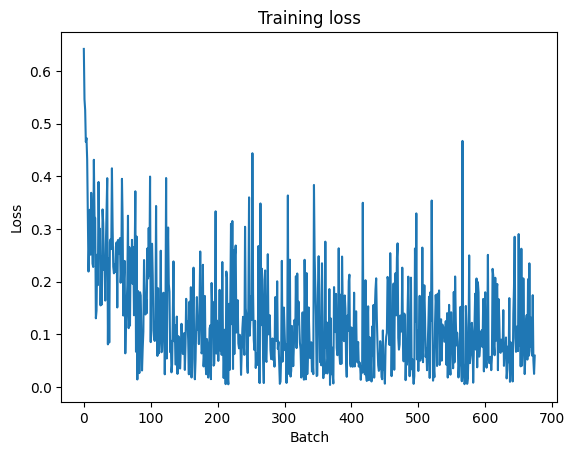

Loss на обучающей выборке: 0.12816
Процент правильных предсказаний на валидационной выборке: 96.25%


In [ ]:
# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()

for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch. tensor(b_input_ids). to (torch. int64)
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()

    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())

    # Backward pass
    loss[0].backward()

    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()

    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()

print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)

    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch. tensor(b_input_ids). to (torch. int64)
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.array(label_ids)
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [ ]:
print("f1_score: {0:.2f}%".format(f1_score(valid_labels, valid_preds)))

f1_score: 0.82%


> Показатель метрики F1 довольно высокий. Необходимо роверить, не переобучилась ли модель.

#### Оценка качества модели на тестовой выборке:

In [ ]:
# Проведём такую же предобработку для тестовой выбоки:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x[:MAX_LEN]) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=MAX_LEN,
    dtype="long",
    truncating="post",
    padding="post"
)

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data,
    sampler=SequentialSampler(prediction_data),
    batch_size=BATCH_SIZE
)

In [ ]:
start = time.time()
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)

    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    b_input_ids = torch. tensor(b_input_ids). to (torch. int64)
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.array(label_ids)
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

end = time.time()
time_fit_bert = end - start

In [ ]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на тестовой выборке составил: {0:.2f}%'.format(acc_score*100))

Процент правильных предсказаний на тестовой выборке составил: 96.82%


In [ ]:
f1_bert = f1_score(test_labels, test_preds)

In [ ]:
result_write('BERT', f1_bert, time_fit_bert)

F1_predict     Time_fit
LinearSVC             0.799069  1567.526717
Catboost              0.695833   124.345692
Word2Vec + Catboost   0.686667   133.479094
BERT                  0.841756    55.760272

# Вывод
<ol>
    <li>Во время проекта изучили и подготовили данные:</li>
    <ul>
        <li>посмотрели общую информацию о данных;</li>
        <li>убедились, что пропуски отсутствуют;</li>
        <li>провели предобработку текста (удалили лишние символы, убрали стоп-слова);</li>
        <li>сделали визуализацию, которая показывает какие слова чаще всего встречаются в комментариях разной тональности.</li></ul>
    <li>обучили следующие модели: LinearSVC, CatBoostClassifier и Word2Vec + CatBoostClassifier и BERT. Модель CatBoostClassifier не справилась с поставленной задачей - достичь метрику качества F1 не меньше 0.75. Причем модель CatBoostClassifier не показала значительного улучшения показателей метрики F1 при работе с векторным представлением текста (F1 = 0.68) или с исходными текстами (F1 = 0.69). </li>
    <li>Как более быструю в обучении модель для классификации комментариев можно рекомендовать модель BERT, которая дает результат F1 = 0.841.
    </ol>